<a href="https://colab.research.google.com/github/LoopMint/angelatancapstone-app/blob/main/CP_Read_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use Gradio to create web apps that displays csv data onto an interactive user interface**

In [11]:
#use the latest version
!pip install --upgrade gradio

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/util

# **Use ReportLab library to download into PDF**

In [12]:
!pip install reportlab

#**Use TensorFlow to build neural networks and train models to make predictions on university rankings.**

In [13]:
!pip install tensorflow

# **Prompt user to upload the QS Ranking CSV File**

In [14]:
from google.colab import files

#triggers a file picker dialog in browser
uploaded = files.upload()

# Get the uploaded file name dynamically
for fn in uploaded.keys():
    file_path = fn
    print(f"File uploaded: {file_path}")


Saving QSRanking.csv to QSRanking (1).csv
File uploaded: QSRanking (1).csv


# **Import libraries**

*   pandas as pd → for loading CSV
*   gradio as gr → for building the interactive web app & dashboard.
*   tensorflow / keras → for building and training deep learning models (classification, regression, Siamese).
*   numpy as np → for numerical operations.
*   sklearn.preprocessing.StandardScaler → scales your features so they have mean =  0 and standard deviation = 1  #this is a data preprocessing tool for dataset to make DLM accurate and stable, otherwise bias towards large numeric values.
*   sklearn.model_selection.train_test_split → splits data into training + testing validation sets.
*   matplotlib.pyplot as plt → creates charts and plots.
*   io.BytesIO + base64 → converts plots/images so they can be displayed in Gradio.
*   reportlab → generates PDF reports (eg. for pairwise ranking analysis).
*   tempfile → creates temporary files for storing charts and PDFs before download.
*   os → interact with operating system

📊 Total records: 1403 universities


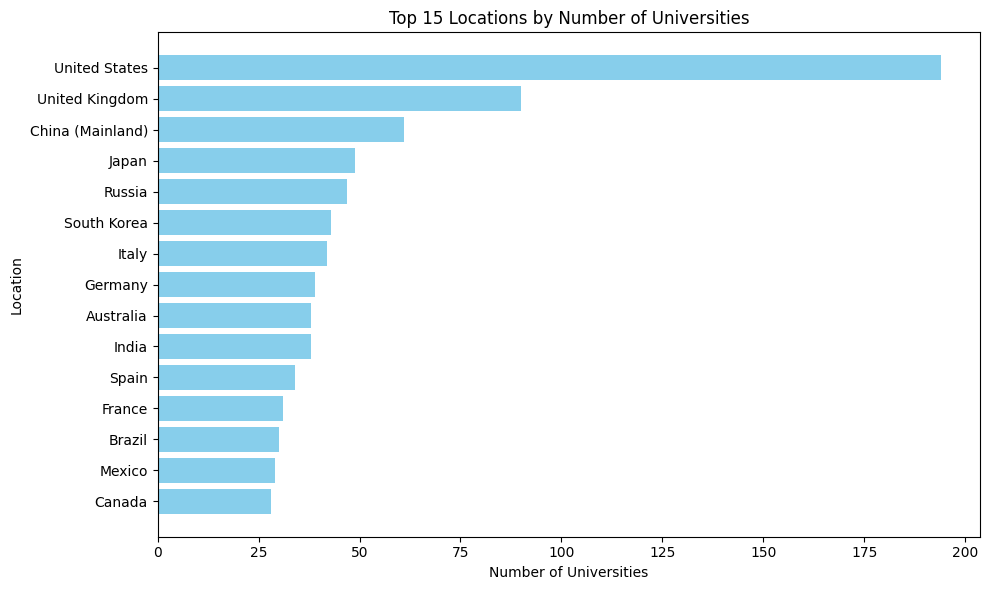

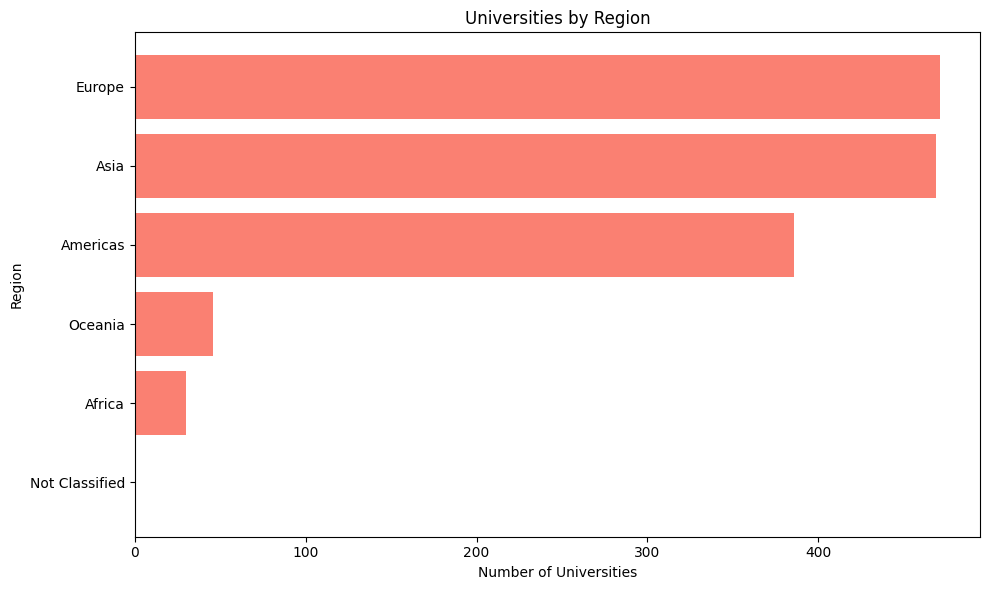

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
📊 Regression Model Evaluation
Model trained to predict QS RANK_2025 based on academic metrics.
                      Metric         Value
0  Mean Absolute Error (MAE)    217.692515
1   Mean Squared Error (MSE)  77440.716909
2                   R² Score      0.743810


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import metrics
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os
import gradio as gr

# Load and clean data
file_path = 'QSRanking.csv'  # replace with your actual path
df = pd.read_csv(file_path, encoding='latin1')
if 'RANK_2024' in df.columns:
    df = df.drop(columns=['RANK_2024'])
df['RANK_2025'] = pd.to_numeric(df['RANK_2025'], errors='coerce').fillna(1402)
df['Top100'] = np.where(df['RANK_2025'] <= 100, 1, 0)
feature_cols = ['Academic_Reputation_Score', 'Employer_Reputation_Score',
                'Citations_per_Faculty_Score', 'Faculty_Student_Score',
                'International_Faculty_Score']
df = df.dropna(subset=feature_cols + ['Institution_Name', 'Top100'])


X = df[feature_cols].values
y_class = df['Top100'].values
y_reg = df['RANK_2025'].values

# Summary statistics
print(f"📊 Total records: {df.shape[0]} universities")

# Top 15 Locations
if 'Location' in df.columns:
    loc_counts = df['Location'].value_counts().nlargest(15)
    plt.figure(figsize=(10, 6))
    plt.barh(loc_counts.index[::-1], loc_counts.values[::-1], color='skyblue')
    plt.title("Top 15 Locations by Number of Universities")
    plt.xlabel("Number of Universities")
    plt.ylabel("Location")
    plt.tight_layout()
    plt.show()

# Universities by Region
if 'Region' in df.columns:
    reg_counts = df['Region'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.barh(reg_counts.index[::-1], reg_counts.values[::-1], color='salmon')
    plt.title("Universities by Region")
    plt.xlabel("Number of Universities")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Classification Model
X_train, X_val, y_train_c, y_val_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
model_class = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_class.fit(X_train, y_train_c, epochs=20, validation_data=(X_val, y_val_c), verbose=0)

# Regression Model
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
model_reg = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_reg.fit(X_train_r, y_train_r, epochs=20, validation_data=(X_val_r, y_val_r), verbose=0)

# Evaluate model
y_pred = model_reg.predict(X_val_r) # Use X_val_r and y_val_r for evaluation
mae = mean_absolute_error(y_val_r, y_pred)
mse = mean_squared_error(y_val_r, y_pred)
r2 = r2_score(y_val_r, y_pred)

# Show evaluation metrics
# Assuming st is streamlit, which is not imported. Replacing with print for now.
print("📊 Regression Model Evaluation")
print("Model trained to predict QS RANK_2025 based on academic metrics.")

metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score'],
    'Value': [mae, mse, r2]
})
print(metrics_df)

# Siamese Model
def build_siamese_model(input_dim):
    base = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu')
    ])
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))
    encoded_a = base(input_a)
    encoded_b = base(input_b)
    diff = layers.Subtract()([encoded_a, encoded_b])
    out = layers.Dense(1, activation='sigmoid')(diff)
    return Model([input_a, input_b], out)

model_rank = build_siamese_model(X.shape[1])
model_rank.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def create_pairs(X, y_rank):
    pairs_a, pairs_b, labels = [], [], []
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            pairs_a.append(X[i])
            pairs_b.append(X[j])
            labels.append(1 if y_rank[i] < y_rank[j] else 0)
    return np.array(pairs_a), np.array(pairs_b), np.array(labels)

X_a, X_b, y_rank_pair = create_pairs(X_scaled, y_reg)
model_rank.fit([X_a, X_b], y_rank_pair, epochs=5, batch_size=256, verbose=0)

# Gradio Functions
def predict_university(univ_input, model_type):
    matched = df[df['Institution_Name'].str.lower().str.contains(univ_input.lower())]
    if matched.empty:
        return "University not found.", "", ""
    inst = matched.iloc[0]
    X_input = scaler.transform(inst[feature_cols].values.reshape(1, -1))
    if model_type == "Classification":
        prob = model_class.predict(X_input)[0][0] * 100
        expected = "HIGH" if inst['RANK_2025'] <= 100 else "LOW"
        return f"🔢 RANK_2025: {inst['RANK_2025']} → Expected: {expected}", f"📈 Predicted Top 100 Probability: {prob:.1f}%", ""
    else:
        pred_rank = model_reg.predict(X_input)[0][0]
        percentage = (pred_rank / 1402) * 100
        actual = inst['RANK_2025']
        print(f"The model estimated a lower rank ({pred_rank:.1f}) for a top university ({univ_input}, actual rank {actual}) because it doesn’t see everything QS sees.")
        return f"🔢 Actual RANK_2025: {actual}", f"📈 Predicted RANK_2025: {pred_rank:.1f} ({percentage:.1f}%)", ""

def compare_universities(univ_a, univ_b):
    u1 = df[df['Institution_Name'].str.lower().str.contains(univ_a.lower())]
    u2 = df[df['Institution_Name'].str.lower().str.contains(univ_b.lower())]
    if u1.empty or u2.empty:
        return "One or both universities not found."
    X1 = scaler.transform(u1.iloc[0][feature_cols].values.reshape(1, -1))
    X2 = scaler.transform(u2.iloc[0][feature_cols].values.reshape(1, -1))
    prob = model_rank.predict([X1, X2])[0][0] * 100
    better = u1.iloc[0]['Institution_Name'] if prob >= 50 else u2.iloc[0]['Institution_Name']
    actual_rank_1 = u1.iloc[0]['RANK_2025']
    actual_rank_2 = u2.iloc[0]['RANK_2025']
    print(f"The model estimated {better} to be better ranked between ({univ_a}, actual rank {actual_rank_1}) and ({univ_b}, actual rank {actual_rank_2}) based on limited features.")
    return f"Predicted better ranked: {better} (Prob A better: {prob:.1f}%)"

def show_top10():
    top10 = df.nsmallest(10, 'RANK_2025')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(top10['Institution_Name'], top10['RANK_2025'], color='green')
    ax.set_xlabel("RANK_2025")
    ax.set_title("Top 10 Universities by RANK_2025")
    ax.invert_yaxis()
    plt.tight_layout()
    img_buf = BytesIO()
    fig.savefig(img_buf, format='png')
    img_buf.seek(0)
    plt.close(fig)
    img_base64 = base64.b64encode(img_buf.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_base64}"/>'

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🌟 2025 QS University Ranking AI Dashboard")
    gr.Markdown("Data source: QS World University Rankings 2025")

    # New Tab - Dataset Overview
    with gr.Tab("📄 Raw Dataset"):
        gr.Dataframe(value=df, label="University Dataset", interactive=False, wrap=True)
        dataframe_output = gr.Dataframe(value=df, label="QS Ranking Data")
        total_records = df.shape[0]
        total_regions = df['Region'].nunique() if 'Region' in df.columns else "N/A"
        total_locations = df['Location'].nunique() if 'Location' in df.columns else "N/A"
        summary = (
            f"**Total Records:** {total_records} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Regions:** {total_regions} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Locations:** {total_locations}"
        )
        gr.Markdown(summary)

    # Existing Tabs
    with gr.Tab("University Ranking Prediction"):
        univ_input = gr.Textbox(label="Enter university name:")
        model_type = gr.Radio(["Classification", "Regression"], label="Select model type:")
        predict_button = gr.Button("Predict")
        prediction_output1 = gr.Textbox(label="Prediction Result 1")
        prediction_output2 = gr.Textbox(label="Prediction Result 2")

    with gr.Tab("Pairwise Ranking"):
        with gr.Row():
            univ_a = gr.Textbox(label="University A")
            univ_b = gr.Textbox(label="University B")
        compare_button = gr.Button("Compare")
        comparison_message = gr.Textbox(label="Comparison Result")

    with gr.Tab("Top 10 Universities"):
        top10_image = gr.HTML()

    # Connect buttons
    predict_button.click(predict_university, inputs=[univ_input, model_type], outputs=[prediction_output1, prediction_output2])
    compare_button.click(compare_universities, inputs=[univ_a, univ_b], outputs=[comparison_message])
    demo.load(show_top10, outputs=top10_image)

demo.launch(debug=True)